In [1]:
# Mounting Google Drive
from google.colab import drive
from os.path import join
ROOT = '/content/drive'
print(ROOT)
drive.mount(ROOT)

/content/drive
Mounted at /content/drive


In [2]:
%cd /content/drive/My\ Drive/Colab\ Notebooks/ProjectData/FaceRecognition/

/content/drive/My Drive/Colab Notebooks/ProjectData/FaceRecognition


In [3]:
face_path = '/content/drive/My Drive/Colab Notebooks/ProjectData/FaceRecognition/dataset2/'
drive_path_checkpoint = '/content/drive/My Drive/Colab Notebooks/ProjectData/FaceRecognition/pickle/checkpoint/face_VGG16_4.hdf5'
VM_path = '/content'
drive_path = 'content/drive/MyDrive/Colab Notebooks/ProjectData/FaceRecognition/'
VM_face_path = '/content/dataset2'
VM_face_aug_path = '/content/dataset'
face_detection_path= "face_detection_model/res10_300x300_ssd_iter_140000.caffemodel"
proto_path = "face_detection_model/deploy.prototxt"

In [ ]:
#!cp -r '{face_path}' '{VM_path}'

In [ ]:
!mkdir /content/dataset2

In [ ]:
!rm -r /content/dataset2/*

rm: cannot remove '/content/dataset2/*': No such file or directory


In [ ]:
!mkdir /content/dataset

In [ ]:
!rm -r /content/dataset/*

rm: cannot remove '/content/dataset/*': No such file or directory


In [ ]:
%ls /content/dataset/

In [26]:

from keras.layers import Input, Lambda, Dense, Flatten
from keras.models import Model
from keras.applications.vgg16 import VGG16
from keras.applications.vgg16 import preprocess_input
from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ModelCheckpoint
from keras.models import Sequential
import numpy as np
from glob import glob
import matplotlib.pyplot as plt
import os
import cv2
from google.colab.patches import cv2_imshow
import pickle
import random
import tensorflow as tf



In [5]:
print("Loading face detector.....")
detector = cv2.dnn.readNetFromCaffe(proto_path, face_detection_path)

Loading face detector.....


In [ ]:
# run this if do not have the face roi. What this code does if if produces 5 augmentaions for each image in the dataset
datagen = ImageDataGenerator(
    rotation_range = 10,
    width_shift_range = 0.2,
    height_shift_range = 0.2,
    zoom_range = 0.2,
    horizontal_flip = True,
    fill_mode='nearest')

image_size = 224
NUMBER_TO_AUGMENT = 5
c = 0
labelConverter = {}
dirpath = face_path
paths = os.listdir(dirpath)
#known_face = []
 
for directory in paths:
    !mkdir '/content/dataset/{directory}'
    labelConverter[directory] = c
    c+=1
print(labelConverter)
for p in paths:
    label = labelConverter[p]
    aug_save_path = VM_face_aug_path+'/'+p
    for p1 in os.listdir(dirpath+'/'+p):
      num_aug = 0
      try:
          path = dirpath+'/'+p+'/'+p1
          img = cv2.imread(path)
          #img = cv2.resize(img,(image_size, image_size))
          img_np = np.asarray(img)
          img_np = np.expand_dims(img_np,0)
          print("Image size = ",img_np.shape)
          it = datagen.flow(img_np, batch_size=1, save_to_dir=aug_save_path, save_prefix='celeb', save_format='png')
          while  num_aug < NUMBER_TO_AUGMENT:
            it.next()
            print(num_aug+1,'th augmenatation of',path)
            num_aug += 1
      except Exception as e:
          print("Error",e)




Streaming output truncated to the last 5000 lines.
4 th augmenatation of /content/drive/My Drive/Colab Notebooks/ProjectData/FaceRecognition/dataset2//Ajay_Devgn/10.jpg
5 th augmenatation of /content/drive/My Drive/Colab Notebooks/ProjectData/FaceRecognition/dataset2//Ajay_Devgn/10.jpg
Image size =  (1, 450, 620, 3)
1 th augmenatation of /content/drive/My Drive/Colab Notebooks/ProjectData/FaceRecognition/dataset2//Ajay_Devgn/12.jpg
2 th augmenatation of /content/drive/My Drive/Colab Notebooks/ProjectData/FaceRecognition/dataset2//Ajay_Devgn/12.jpg
3 th augmenatation of /content/drive/My Drive/Colab Notebooks/ProjectData/FaceRecognition/dataset2//Ajay_Devgn/12.jpg
4 th augmenatation of /content/drive/My Drive/Colab Notebooks/ProjectData/FaceRecognition/dataset2//Ajay_Devgn/12.jpg
5 th augmenatation of /content/drive/My Drive/Colab Notebooks/ProjectData/FaceRecognition/dataset2//Ajay_Devgn/12.jpg
Image size =  (1, 698, 600, 3)
1 th augmenatation of /content/drive/My Drive/Colab Notebooks

In [ ]:
# this uploads the augmented dataset from VM to drive
!cp -r '{VM_face_aug_path}' '/content/drive/MyDrive/'

In [6]:
face_dec = cv2.CascadeClassifier(cv2.data.haarcascades+'haarcascade_frontalface_default.xml')

In [7]:
def getFace_CV2DNN(image):
  (h,w) = image.shape[:2]
  blob = cv2.dnn.blobFromImage(cv2.resize(image, (300,300)),1.0, (300,300),(104.0, 177.0, 123.0), swapRB= False, crop = False)
  detector.setInput(blob)
  detections = detector.forward()
  max = -1
  fHM = 0
  fWM = 0
  x1 = 0
  x2=0
  y1=0
  y2 = 0
  for i in range(0,detections.shape[2]):
    confidence = detections[0,0,i,2];
    
    if confidence < 0.7:
      continue

    box = detections[0, 0, i, 3:7] * np.array([w, h, w, h])
    (startX, startY, endX, endY) = box.astype("int")
    cv2.rectangle(image, (startX, startY), (endX, endY), (0,0,255), 2)
    
    
    fH = endX - startX
    fW = endY - startY
    #print("ggg-",fW,fH)
    if fH < 20 or fW < 20:
      continue
    area = fH*fW
    if max < area:
      max = area
      x1 = startX
      x2 = endX
      y1 = startY
      y2 = endY
  return x1,x2,y1,y2


In [8]:
def getFace_haar(image):
  max = -1
  x1 = 0
  x2=0
  y1=0
  y2 = 0
  faces = face_dec.detectMultiScale(image, 1.3,5)
  for (x,y,w,h) in faces:
    #print(w,h)
    if w < 20 or h <20:
      continue
    area = h*w
    if max < area:
      max = area
      x1 = x
      y1 = y
      x2 = x+w
      y2 = y+h

    return x1, x2, y1, y2
    

In [ ]:
# Run this if you want to get face_roi from augmented images  
#knownface = []
count = 0
k = 1
facelabels = os.listdir(VM_face_aug_path)
for f in facelabels:
  sorc = VM_face_aug_path+'/'+f
  dest = VM_face_path+'/'+f
  os.mkdir(dest)
  img_list = os.listdir(sorc)
  print('Processing ',f, str(k), 'out of ', str(len(facelabels)), 'classes')
  k += 1
  for img in img_list:
    imgPath = sorc+'/'+img
    image = cv2.imread(imgPath)
    #faces = face_dec.detectMultiScale(image)
    print(image.shape)
    cord = getFace_CV2DNN(image)
    if cord == None:
      continue
    x1,x2, y1, y2 = cord
    try:
      image = cv2.cvtColor(image,cv2.COLOR_BGR2GRAY)
      face = image[y1:y2, x1:x2]
      
      savepath = dest+'/'+str(count)+'.png'
      count += 1
      
      cv2.imwrite(savepath, face)
    except Exception as e:
      print('Error: ',e) 

Streaming output truncated to the last 5000 lines.
(1372, 939, 3)
Error:  OpenCV(4.1.2) /io/opencv/modules/imgcodecs/src/loadsave.cpp:715: error: (-215:Assertion failed) !_img.empty() in function 'imwrite'

(1600, 1067, 3)
(1080, 1080, 3)
Error:  OpenCV(4.1.2) /io/opencv/modules/imgcodecs/src/loadsave.cpp:715: error: (-215:Assertion failed) !_img.empty() in function 'imwrite'

(397, 300, 3)
(1019, 775, 3)
Error:  OpenCV(4.1.2) /io/opencv/modules/imgcodecs/src/loadsave.cpp:715: error: (-215:Assertion failed) !_img.empty() in function 'imwrite'

(1506, 1280, 3)
Error:  OpenCV(4.1.2) /io/opencv/modules/imgcodecs/src/loadsave.cpp:715: error: (-215:Assertion failed) !_img.empty() in function 'imwrite'

(455, 610, 3)
Error:  OpenCV(4.1.2) /io/opencv/modules/imgcodecs/src/loadsave.cpp:715: error: (-215:Assertion failed) !_img.empty() in function 'imwrite'

(1414, 888, 3)
(720, 1280, 3)
Error:  OpenCV(4.1.2) /io/opencv/modules/imgcodecs/src/loadsave.cpp:715: error: (-215:Assertion failed) !_im

In [ ]:
# run this if ypou want to upload the face_roi from VM to google drive 
%cp -r '/content/dataset2' '/content/drive/MyDrive'

In [9]:
# run this if you want to download the face_roi from google drive to VM
!cp -r '/content/drive/MyDrive/dataset2' '/content'

In [10]:
!ls -la /content/dataset2

total 324
drwx------ 22 root root  4096 May 24 05:53 .
drwxr-xr-x  1 root root  4096 May 24 05:11 ..
drwx------  2 root root 20480 May 24 05:53 Aamir_Khan
drwx------  2 root root 12288 May 24 05:44 Abhay_Deol
drwx------  2 root root 12288 May 24 05:25 Abhishek_Bachchan
drwx------  2 root root 12288 May 24 05:13 Aftab_Shivdasani
drwx------  2 root root 20480 May 24 05:38 Aishwarya_Rai
drwx------  2 root root 16384 May 24 05:32 Ajay_Devgn
drwx------  2 root root 16384 May 24 05:23 Akshay_Kumar
drwx------  2 root root 20480 May 24 05:16 Alia_Bhatt
drwx------  2 root root 20480 May 24 05:56 Amitabh_Bachchan
drwx------  2 root root 12288 May 24 05:18 Anil_Kapoor
drwx------  2 root root 20480 May 24 05:35 Anushka_Sharma
drwx------  2 root root 12288 May 24 05:40 Arshad_Warsi
drwx------  2 root root 16384 May 24 05:48 Ayushmann_Khurrana
drwx------  2 root root 12288 May 24 05:46 Bhumi_Pednekar
drwx------  2 root root 20480 May 24 05:43 Deepika_Padukone
drwx------  2 root root 20480 May 24 05:

In [ ]:
!rm -r /content/dataset/.ipynb_checkpoints

In [11]:
# re-size all the images to this
IMAGE_SIZE = [224, 224]

train_path = VM_face_path

# add preprocessing layer to the front of VGG
vgg = VGG16(input_shape=IMAGE_SIZE + [3], weights='imagenet', include_top=False)

# don't train existing weights
for layer in vgg.layers:
  layer.trainable = False

# useful for getting number of classes
folders = glob(train_path+'/*')
  

  

58892288/58889256 [==============================] - 0s 0us/step


In [12]:
for l in vgg.layers[-1:]:
  l.trainable = True
vgg.summary()
for l in vgg.layers:
  print(l, l.trainable)

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

In [13]:
x = Flatten()(vgg.output)
x = Dense(512, activation='relu')(x)
x = Dense(512,activation='relu')(x)
prediction = Dense(len(folders), activation='softmax')(x)

# create a model object
model = Model(inputs=vgg.input, outputs=prediction)

# view the structure of the model
model.summary()



Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

In [31]:

checkpoint_filepath = drive_path_checkpoint
model_checkpoint = ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True, save_freq='epoch')




In [32]:
# tell the model what cost and optimization method to use
model.compile(
  loss='categorical_crossentropy',
  optimizer='adam',
  metrics=['accuracy',
           tf.keras.metrics.Precision(),
           tf.keras.metrics.Recall()]
)

In [33]:

from keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(rescale = 1./255,
                                   rotation_range=10,
                                   horizontal_flip=True,
                                   brightness_range = [0.5,1.5],
                                   validation_split=0.2)

training_set = train_datagen.flow_from_directory(train_path,
                                                 target_size = IMAGE_SIZE,
                                                 batch_size = 32,
                                                 class_mode = 'categorical', 
                                                 subset='training')

testing_set = train_datagen.flow_from_directory(train_path,
                                                 target_size = IMAGE_SIZE,
                                                 batch_size = 32,
                                                 class_mode = 'categorical', 
                                                 subset='validation')




Found 8250 images belonging to 20 classes.
Found 2051 images belonging to 20 classes.


In [34]:
training_set.class_indices

{'Aamir_Khan': 0,
 'Abhay_Deol': 1,
 'Abhishek_Bachchan': 2,
 'Aftab_Shivdasani': 3,
 'Aishwarya_Rai': 4,
 'Ajay_Devgn': 5,
 'Akshay_Kumar': 6,
 'Alia_Bhatt': 7,
 'Amitabh_Bachchan': 8,
 'Anil_Kapoor': 9,
 'Anushka_Sharma': 10,
 'Arshad_Warsi': 11,
 'Ayushmann_Khurrana': 12,
 'Bhumi_Pednekar': 13,
 'Deepika_Padukone': 14,
 'Disha_Patani': 15,
 'Emraan_Hashmi': 16,
 'Farhan_Akhtar': 17,
 'Hrithik_Roshan': 18,
 'Ileana_D_Cruz': 19}

In [35]:
testing_set.class_indices

{'Aamir_Khan': 0,
 'Abhay_Deol': 1,
 'Abhishek_Bachchan': 2,
 'Aftab_Shivdasani': 3,
 'Aishwarya_Rai': 4,
 'Ajay_Devgn': 5,
 'Akshay_Kumar': 6,
 'Alia_Bhatt': 7,
 'Amitabh_Bachchan': 8,
 'Anil_Kapoor': 9,
 'Anushka_Sharma': 10,
 'Arshad_Warsi': 11,
 'Ayushmann_Khurrana': 12,
 'Bhumi_Pednekar': 13,
 'Deepika_Padukone': 14,
 'Disha_Patani': 15,
 'Emraan_Hashmi': 16,
 'Farhan_Akhtar': 17,
 'Hrithik_Roshan': 18,
 'Ileana_D_Cruz': 19}

In [37]:
r = model.fit(
  training_set,
  validation_data=testing_set,
  epochs=32,
  callbacks = [model_checkpoint]
)

Epoch 1/32
258/258 [==============================] - 126s 489ms/step - loss: 0.1105 - accuracy: 0.9659 - precision_1: 0.9747 - recall_1: 0.9601 - val_loss: 0.3999 - val_accuracy: 0.9069 - val_precision_1: 0.9351 - val_recall_1: 0.8986
Epoch 2/32
258/258 [==============================] - 126s 489ms/step - loss: 0.1157 - accuracy: 0.9651 - precision_1: 0.9730 - recall_1: 0.9594 - val_loss: 0.4736 - val_accuracy: 0.9010 - val_precision_1: 0.9262 - val_recall_1: 0.8874
Epoch 3/32
258/258 [==============================] - 126s 490ms/step - loss: 0.0886 - accuracy: 0.9728 - precision_1: 0.9801 - recall_1: 0.9678 - val_loss: 0.4868 - val_accuracy: 0.9059 - val_precision_1: 0.9299 - val_recall_1: 0.8996
Epoch 4/32
258/258 [==============================] - 126s 490ms/step - loss: 0.1215 - accuracy: 0.9636 - precision_1: 0.9730 - recall_1: 0.9576 - val_loss: 0.5392 - val_accuracy: 0.8913 - val_precision_1: 0.9091 - val_recall_1: 0.8830
Epoch 5/32
258/258 [==============================] - 12

In [38]:
model_path = '/content/drive/My Drive/Colab Notebooks/ProjectData/FaceRecognition/pickle/transferVGG16_4_celeb_dataset.h5'
model.save(model_path)

In [58]:
NB_EPOCHS = 32np.abs(np.subtract(val_loss_trace,loss_trace))
m = []
for i in range(1,NB_EPOCHS+1):
  m.append(i)

In [82]:
np.abs(np.subtract(val_loss_trace,loss_trace))

array([0.28942319, 0.35783141, 0.39816639, 0.41773154, 0.37184228,
       0.42041356, 0.38316108, 0.33940692, 0.37369286, 0.40305932,
       0.33275798, 0.43788427, 0.36975735, 0.39963533, 0.40652437,
       0.42091168, 0.37922366, 0.37667319, 0.41920434, 0.39751485,
       0.36218341, 0.4742543 , 0.42374871, 0.37538294, 0.45660637,
       0.39439207, 0.35210354, 0.39280443, 0.45117202, 0.41138851,
       0.38893078, 0.31809541])

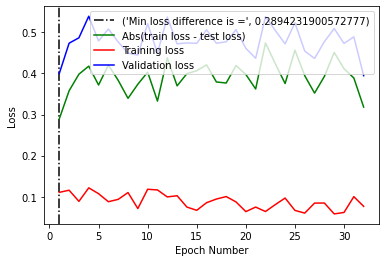

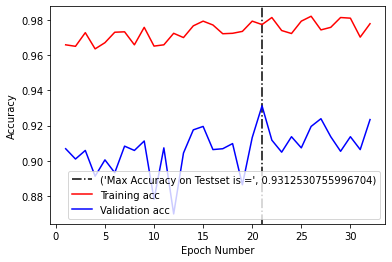

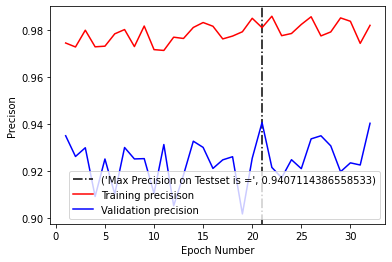

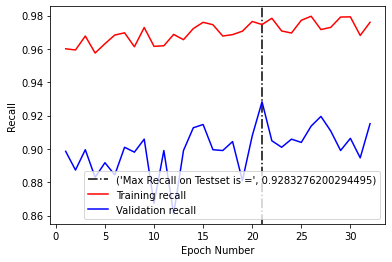

In [88]:

loss_trace = r.history['loss']
val_loss_trace = r.history['val_loss']
delta = np.abs(np.subtract(val_loss_trace,loss_trace))
min_lo = np.argmin(delta) +1# +1 because the indexing starts from 1
plt.axvline(x=min_lo,c = 'k', linestyle='-.')
s = 'Min loss difference is =',delta[min_lo-1]

plt.plot(m,delta, c = 'g')
plt.plot(m,loss_trace, c='r')
plt.plot(m,val_loss_trace, c='b')
plt.xlabel('Epoch Number')
plt.ylabel('Loss')
plt.legend([s,'Abs(train loss - test loss)','Training loss', 'Validation loss'], loc='upper right')
plt.show()


accuracy_trace = r.history['accuracy']
val_accuracy_trace = r.history['val_accuracy']

max_acc = np.argmax(val_accuracy_trace) +1 # +1 because the indexing starts from 1
plt.axvline(x=max_acc,c = 'k', linestyle='-.')
s0 = 'Max Accuracy on Testset is =',val_accuracy_trace[max_acc-1]

plt.plot(m,accuracy_trace, c='r')
plt.plot(m,val_accuracy_trace, c='b')
plt.xlabel('Epoch Number')
plt.ylabel('Accuracy')
plt.legend([s0,'Training acc', 'Validation acc'], loc='lower right')
plt.show()


precision_trace = r.history['precision_1']
val_precision_trace = r.history['val_precision_1']

max_pre = np.argmax(val_precision_trace) +1 # +1 because the indexing starts from 1
plt.axvline(x=max_pre,c = 'k', linestyle='-.')
s1 = 'Max Precision on Testset is =',val_precision_trace[max_pre-1]

plt.plot(m,precision_trace, c='r')
plt.plot(m,val_precision_trace, c='b')
plt.xlabel('Epoch Number')
plt.ylabel('Precison')
plt.legend([s1,'Training precisison', 'Validation precision'], loc='lower right')
plt.show()


recall_trace = r.history['recall_1']
val_recall_trace = r.history['val_recall_1']


max_recall = np.argmax(val_recall_trace) +1 # +1 because the indexing starts from 1
plt.axvline(x=max_recall,c = 'k', linestyle='-.')
s2 = 'Max Recall on Testset is =',val_recall_trace[max_recall-1]


plt.plot(m,recall_trace, c='r')
plt.plot(m,val_recall_trace, c='b')
plt.xlabel('Epoch Number')
plt.ylabel('Recall')
plt.legend([s2,'Training recall', 'Validation recall'], loc='lower right')
plt.show()



In [89]:
f1_score = 2*(np.multiply(precision_trace , recall_trace))/(np.add(precision_trace ,recall_trace))

In [90]:
f1_score

array([0.96733224, 0.96612754, 0.97389606, 0.96523915, 0.96819789,
       0.97343732, 0.97501525, 0.96719513, 0.97735023, 0.96667277,
       0.96668492, 0.97291375, 0.97104895, 0.97674135, 0.97968123,
       0.97816169, 0.9720582 , 0.97308817, 0.97503957, 0.98082423,
       0.9779264 , 0.98223413, 0.97427163, 0.97412167, 0.97988454,
       0.98273347, 0.97464891, 0.97616443, 0.98224707, 0.98159287,
       0.97130002, 0.97908561])

In [91]:
val_f1_score = 2*(np.multiply(val_precision_trace , val_recall_trace))/(np.add(val_precision_trace ,val_recall_trace))
val_f1_score

array([0.91645947, 0.90637451, 0.91449813, 0.8958694 , 0.90814301,
       0.89713155, 0.9153046 , 0.91142996, 0.91549644, 0.88838952,
       0.91490945, 0.88255871, 0.90859816, 0.92262199, 0.92232054,
       0.91021212, 0.91174289, 0.91514553, 0.89124539, 0.91656414,
       0.9344785 , 0.91316114, 0.90900146, 0.91527096, 0.91240159,
       0.92360768, 0.92723696, 0.92065056, 0.9092702 , 0.91486221,
       0.90841584, 0.92760069])

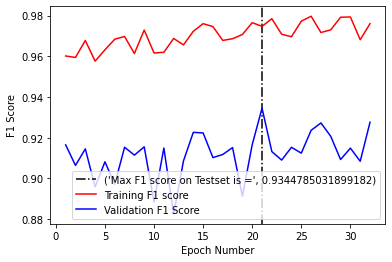

In [92]:

f1_trace = f1_score
val_recall_trace = val_f1_score

max_f1 = np.argmax(val_f1_score) +1 # +1 because the indexing starts from 1
plt.axvline(x=max_f1,c = 'k', linestyle='-.')
s3 = 'Max F1 score on Testset is =',val_f1_score[max_f1-1]

plt.plot(m,recall_trace, c='r')
plt.plot(m,val_recall_trace, c='b')
plt.xlabel('Epoch Number')
plt.ylabel('F1 Score')
plt.legend([s3, 'Training F1 score', 'Validation F1 Score'], loc='lower right')
plt.show()

